In [ ]:
# Standard library
import os
import csv
import random
from pathlib import Path

# HTTP / parsing
import requests
from bs4 import BeautifulSoup

# Scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio.v2 as imageio

# SciPy
from scipy import ndimage as ndi
from scipy.ndimage import binary_fill_holes

# scikit-image
from skimage import (
    io, color, filters, morphology, measure, exposure, segmentation
)
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import (
    gaussian, threshold_otsu, threshold_local, threshold_multiotsu, sobel
)
from skimage.morphology import (
    remove_small_objects, binary_closing, binary_opening, disk
)
from skimage.segmentation import clear_border, watershed
from skimage.feature import peak_local_max

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import copy

# Data augmentation
import albumentations as A
import random


In [ ]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.2/738.2 kB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import mlflow

In [ ]:
BASE_DIR = Path("cell_dataset")
RAW_DIR = BASE_DIR / "raw"
MASK_DIR = BASE_DIR / "masks"
META_DIR = BASE_DIR / "metadata"


for d in [RAW_DIR, MASK_DIR, META_DIR]:
    d.mkdir(parents=True, exist_ok=True)

INDEX_CSV = META_DIR / "dataset_index.csv"


def download_file(url, save_path):
    """Download image if not exists"""
    save_path.parent.mkdir(parents=True, exist_ok=True)
    if not save_path.exists():
        r = requests.get(url, timeout=30)
        if r.status_code == 200:
            with open(save_path, "wb") as f:
                f.write(r.content)
        else:
            print(f"[!] Failed download {url}")


def get_image_urls(ens_id):
    """Get nucleus, cytoplasm, protein URLs for an ENSG id"""
    HPA_url = f"https://v18.proteinatlas.org/{ens_id.split('.')[0]}.xml"
    xml_file = BeautifulSoup(requests.get(HPA_url).text, "xml")

    im_urls = []
    for x in xml_file.find_all("cellExpression"):
        for y in x.find_all("data"):
            for n in y.find_all("cellLine"):
                for im in y.find_all("imageUrl"):
                    im_urls.append(
                        im.get_text()
                        .replace("_blue", "")
                        .replace("_red", "")
                        .replace("_green", "")
                        .replace("_blue_red_green", "")
                        .replace(".jpg", "")
                    )

    urls_nuc = [x + "_blue.jpg" for x in im_urls]
    urls_cyt = [x + "_red.jpg" for x in im_urls]
    urls_prot = [x + "_green.jpg" for x in im_urls]
    urls_comb = [x + "_blue_red_green.jpg" for x in im_urls]

    return list(zip(urls_nuc, urls_cyt, urls_prot, urls_comb))



def build_dataset(ens_ids):
    # prepare CSV header
    with open(INDEX_CSV, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["ens_id", "sample_id", "nucleus_path", "cytoplasm_path", "protein_path","comb_path", "mask_path"])

        for ens_id in ens_ids:
            print(f"Processing {ens_id} ...")
            triplets = get_image_urls(ens_id)

            for i, (nuc_url, cyt_url, prot_url, comb_url) in enumerate(triplets, start=1):
                sample_id = f"sample_{i:03d}"

                # directories
                raw_sample_dir = RAW_DIR / ens_id / sample_id
                mask_sample_dir = MASK_DIR / ens_id / sample_id

                # file paths
                nuc_path = raw_sample_dir / "nucleus.jpg"
                cyt_path = raw_sample_dir / "cytoplasm.jpg"
                prot_path = raw_sample_dir / "protein.jpg"
                comb_path = raw_sample_dir / "combined.jpg"
                mask_path = mask_sample_dir / "mask.png"

                # download raw images
                download_file(nuc_url, nuc_path)
                download_file(cyt_url, cyt_path)
                download_file(prot_url, prot_path)
                download_file(comb_url, comb_path)


                writer.writerow([ens_id, sample_id, str(nuc_path), str(cyt_path), str(prot_path),str(comb_path), str(mask_path)])




["ENSG00000181163",
"ENSG00000213782",DDX47
"ENSG00000117133",RPF1
"ENSG00000108651",UTP6
"ENSG00000115761",NOL10
"ENSG00000108592",FTSJ3
"ENSG00000108312"]UBTF
ENSG00000121579, NAA50
ENSG00000105373 NOP53
ENSG00000101361 NOP56
ENSG00000166197 NOLC1
ENSG00000147669 POLR2K
ENSG00000048162 NOP16
ENSG00000141076 UTP4
ENSG00000213782 DDX47
ENSG00000111641 NOP2
ENSG00000108312 UBTF

In [ ]:
if __name__ == "__main__":
    ens_ids = ["ENSG00000181163","ENSG00000213782","ENSG00000117133","ENSG00000108651","ENSG00000115761","ENSG00000108592","ENSG00000108312","ENSG00000121579", "ENSG00000105373","ENSG00000101361","ENSG00000166197", "ENSG00000147669", "ENSG00000048162", "ENSG00000141076",  "ENSG00000213782", "ENSG00000111641", "ENSG00000108312" ]
    build_dataset(ens_ids)
    print(f"✅ Dataset built at {BASE_DIR}")
    print(f"✅ Index file: {INDEX_CSV}")

Processing ENSG00000181163 ...
Processing ENSG00000213782 ...
Processing ENSG00000117133 ...
Processing ENSG00000108651 ...
Processing ENSG00000115761 ...
Processing ENSG00000108592 ...
Processing ENSG00000108312 ...
Processing ENSG00000121579 ...
Processing ENSG00000105373 ...
Processing ENSG00000101361 ...
Processing ENSG00000166197 ...
Processing ENSG00000147669 ...
Processing ENSG00000048162 ...
Processing ENSG00000141076 ...
Processing ENSG00000213782 ...
Processing ENSG00000111641 ...
Processing ENSG00000108312 ...
✅ Dataset built at cell_dataset
✅ Index file: cell_dataset/metadata/dataset_index.csv


In [ ]:
def segment_cytoplasm_with_nuclei(image, nuclei_mask):
    _, gray_norm = preprocess_array(image)
    im_blurred = filters.gaussian(gray_norm, sigma=2)

    # Base threshold for foreground
    binary_mask = im_blurred > filters.threshold_otsu(im_blurred)

    # Distance transform from cytoplasm foreground
    distance = ndi.distance_transform_edt(binary_mask)

    # Use nuclei as markers
    labels = measure.label(nuclei_mask)

    # Watershed: expand nuclei into cytoplasm
    cytoplasm_labels = segmentation.watershed(-distance, labels, mask=binary_mask)

    # Convert to binary (1 for cytoplasm region, 0 for background)
    cytoplasm_binary = (cytoplasm_labels > 0).astype(np.uint8)

    return cytoplasm_binary




def segment_nucleus(image):
# Convert to grayscale
  _, gray_norm = preprocess_array(image)

  # Smooth to reduce noise
  im_blurred = filters.gaussian(gray_norm, sigma=1)

  # Threshold (Otsu for global separation)
  thresh = filters.threshold_otsu(im_blurred)
  binary_mask = im_blurred > thresh   # Cytoplasm should appear as True region

  # Morphological cleaning
  mask = morphology.remove_small_objects(binary_mask, min_size=400)
  mask = morphology.remove_small_holes(mask, area_threshold=1000)
  mask = morphology.opening(mask, morphology.disk(3))


  # Fill internal holes
  mask = ndi.binary_fill_holes(mask)
  return mask

def segment_protein(image,grad_threshold=0.1, disk_radius=3):
  _, gray_norm = preprocess_array(image)
  # Multi-Otsu segmentation
  im_blurred = filters.gaussian(gray_norm, sigma=1)
  thresholds = threshold_multiotsu(gray_norm, classes=3)
  regions = np.digitize(gray_norm, bins=thresholds)
    # Select the brightest region (like mask_otsu = regions == 2 in first script)
  mask_otsu = regions == 2

    # Gradient-based mask
  grad_mag = sobel(gray_norm)
  grad_norm = (grad_mag - grad_mag.min()) / (grad_mag.max() - grad_mag.min() + 1e-10)
  grad_mask = grad_norm > grad_threshold

    # Combine intensity + edges
  combined = mask_otsu & grad_mask

    # Morphological cleaning
  cleaned = morphology.binary_closing(combined, morphology.disk(disk_radius))
  cleaned = ndi.binary_fill_holes(cleaned)
  cleaned = clear_border(cleaned)

  return cleaned


def preprocess_array(image, target_size=(512, 512)):
    """Preprocess an image already loaded as a numpy array (like imageio.imread)."""
    # If image has 3 channels, ensure BGR->GRAY
    if len(image.shape) == 3:
        # convert RGB (imageio) -> BGR (cv2 expects BGR)
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image_resized = cv2.resize(image_bgr, target_size)
        gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY).astype(np.float32)
    else:
        # grayscale image
        image_resized = cv2.resize(image, target_size)
        gray = image_resized.astype(np.float32)

    # Normalize [0,1]
    gray = (gray - gray.min()) / (gray.max() - gray.min() + 1e-10)
    return image_resized, gray

In [ ]:
def generate_masks(csv_path):
    df = pd.read_csv(csv_path)

    for i, row in df.iterrows():
        print(f"Segmenting {row['ens_id']} - {row['sample_id']}")

        nuc_img = imageio.imread(row["nucleus_path"])
        cyt_img = imageio.imread(row["cytoplasm_path"])
        prot_img = imageio.imread(row["protein_path"])

        nuc_mask = segment_nucleus(nuc_img)
        cyt_mask = segment_cytoplasm_with_nuclei(cyt_img,nuc_mask)
        prot_mask = segment_protein(prot_img)

        # Binarize cytoplasm (all >0 → 1)
        cyt_mask_bin = (cyt_mask > 0)

        combined_mask = np.zeros_like(nuc_mask, dtype=np.uint8)

        # Assign in order of priority
        combined_mask[cyt_mask_bin] = 2   # cytoplasm
        combined_mask[nuc_mask > 0] = 1   # nucleus
        combined_mask[prot_mask > 0] = 3  # protein


        os.makedirs(os.path.dirname(row["mask_path"]), exist_ok=True)
        imageio.imwrite(row["mask_path"], combined_mask.astype(np.uint8))



        fig, axes = plt.subplots(2, 3, figsize=(12, 8))

        axes[0, 0].imshow(nuc_img, cmap="gray")
        axes[0, 0].set_title("Nucleus (raw)")
        axes[0, 0].axis("off")

        axes[0, 1].imshow(cyt_img, cmap="gray")
        axes[0, 1].set_title("Cytoplasm (raw)")
        axes[0, 1].axis("off")

        axes[0, 2].imshow(prot_img, cmap="gray")
        axes[0, 2].set_title("Protein (raw)")
        axes[0, 2].axis("off")

        axes[1, 0].imshow(nuc_mask, cmap="gray")
        axes[1, 0].set_title("Nucleus mask")
        axes[1, 0].axis("off")

        axes[1, 1].imshow(cyt_mask, cmap="gray")
        axes[1, 1].set_title("Cytoplasm mask")
        axes[1, 1].axis("off")

        axes[1, 2].imshow(combined_mask, cmap="jet")
        axes[1, 2].set_title("Combined mask")
        axes[1, 2].axis("off")

        plt.tight_layout()
        plt.show()




In [ ]:
generate_masks("/content/cell_dataset/metadata/dataset_index.csv")

In [ ]:
class CellSegmentationDataset(Dataset):
    def __init__(self, csv_path, transform=None, use_protein=False):
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.use_protein = use_protein

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]

        img_path = row["protein_path"] if self.use_protein else row["comb_path"]

        # Load combined RGB image
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512, 512))

        # Load combined mask (with class labels 0..3)
        mask = cv2.imread(row["mask_path"], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)
        mask = mask.astype(np.int64)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]


        image = torch.from_numpy(image.transpose(2, 0, 1)).float()  # [H,W,C] to [C,H,W]
        mask = torch.from_numpy(mask).long()
        return image, mask



In [ ]:
transform = A.Compose([
    # Geometric augmentations
    A.RandomRotate90(p=0.5),
    A.Affine(
        scale=(0.97, 1.03),
        translate_percent=(0.01, 0.01),  # smaller translations
        rotate=(-8, 8),
        shear=(-5, 5),
        fit_output=True,  # ✅ ensures no black borders or cropping artifacts
        p=0.6
    ),

    # Elastic + grid distortions
    A.ElasticTransform(alpha=20, sigma=4, alpha_affine_scale=3, p=0.15),
    A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.2),

    # Photometric and noise-based augmentations
    A.OneOf([
        A.RandomBrightnessContrast(
            brightness_limit=0.25,
            contrast_limit=0.25,
            p=0.6
        ),
        A.GaussNoise(var_limit=(10, 20), p=0.4),
    ], p=0.7),

    # Motion blur + random occlusion
    A.MotionBlur(blur_limit=3, p=0.2),
    A.CoarseDropout(
        max_holes=3,          # ✅ fewer holes
        max_height=15,
        max_width=15,
        min_holes=1,
        fill_value=None,      # ✅ uses image mean instead of pure black
        p=0.25
    ),

    # Normalize at the end
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])




# Protein images dataset
protein_dataset = CellSegmentationDataset(
    '/content/cell_dataset/metadata/dataset_index.csv',
    transform=transform,
    use_protein=True
    )

# Combined dataset
complete_dataset = CellSegmentationDataset(
    '/content/cell_dataset/metadata/dataset_index.csv',
    transform=transform,
    use_protein=False
    )


def create_dataloader(dataset):
  total_size = len(dataset)
  train_len = int(0.7 * total_size)
  val_len = int(0.2 * total_size)
  test_len = total_size - train_len - val_len

  train_set, val_set, test_set = torch.utils.data.random_split(
      dataset, [train_len, val_len, test_len]
      )

  train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
  val_loader = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
  test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

  return train_loader, val_loader, test_loader

train_loader_protein, val_loader_protein, test_loader_protein = create_dataloader(protein_dataset)
train_loader, val_loader, test_loader = create_dataloader(complete_dataset)



/tmp/ipython-input-1359968572.py:14: UserWarning: Argument(s) 'alpha_affine_scale' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=20, sigma=4, alpha_affine_scale=3, p=0.15),
/tmp/ipython-input-1359968572.py:24: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 20), p=0.4),
/tmp/ipython-input-1359968572.py:29: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


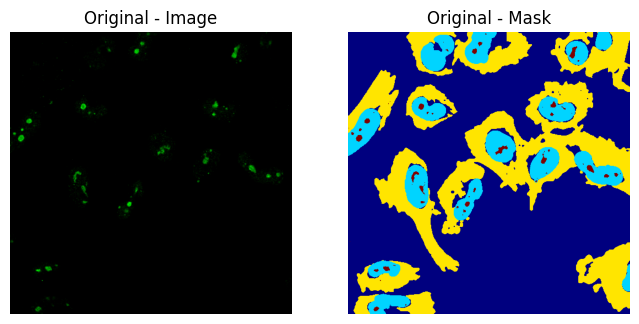

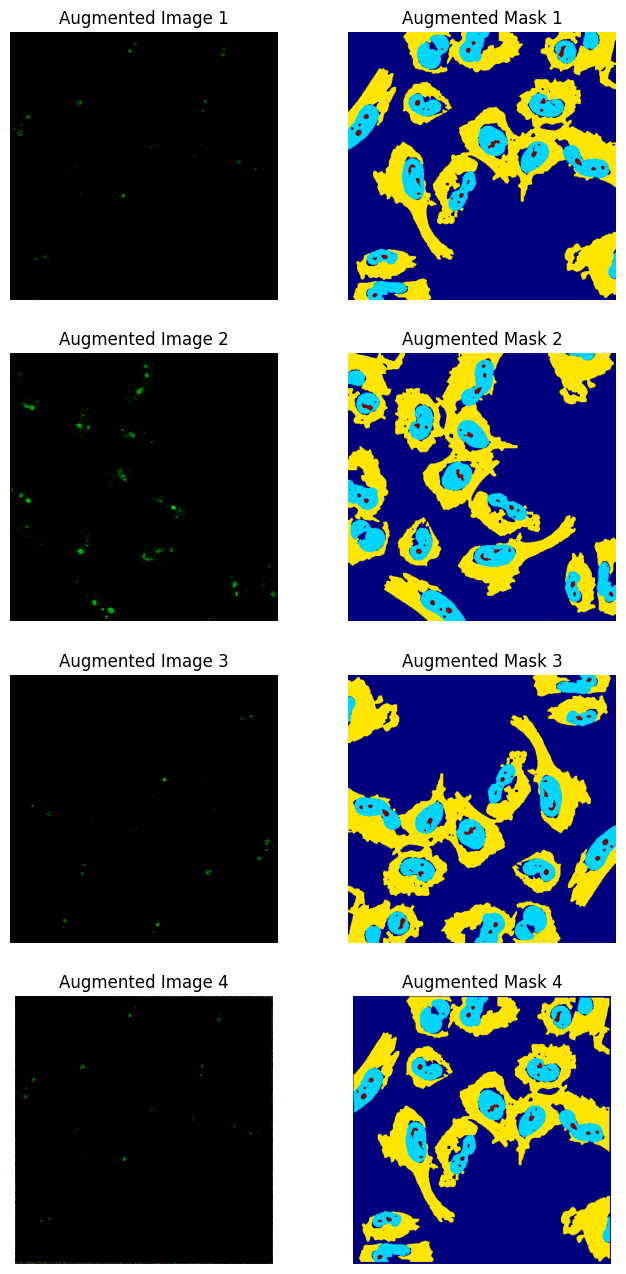

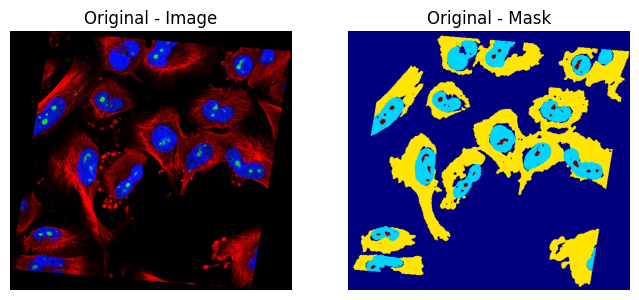

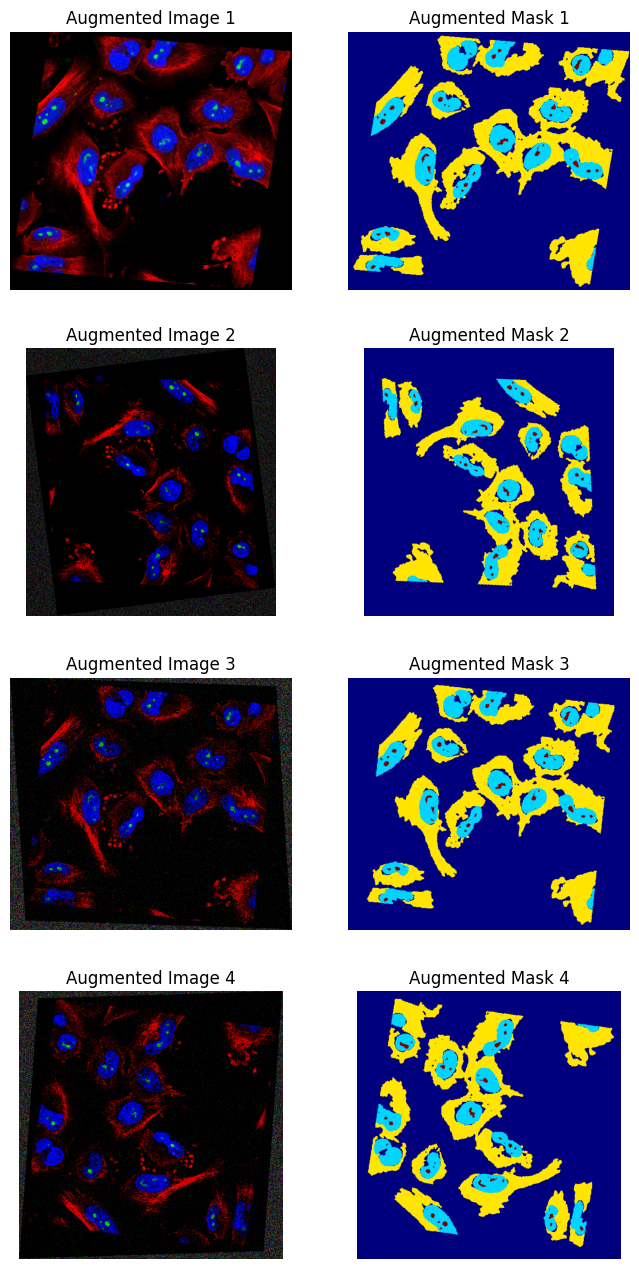

In [ ]:
def show_image_mask(img, mask, title="Original Pair"):
    if torch.is_tensor(img):
        img_np = img.numpy().transpose(1, 2, 0)  # [C,H,W] → [H,W,C]
    else:
        img_np = img
    img_vis = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    img_vis = (img_vis * 255).astype(np.uint8)

    if torch.is_tensor(mask):
        mask_np = mask.numpy()
    else:
        mask_np = mask

    plt.figure(figsize=(8,4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_vis)
    plt.title(f"{title} - Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap="jet")
    plt.title(f"{title} - Mask")
    plt.axis("off")
    plt.show()

def visualize_augmentations(image, mask, transform, n_samples=4):
    fig, axes = plt.subplots(n_samples, 2, figsize=(8, 4*n_samples))
    for i in range(n_samples):
        augmented = transform(image=image, mask=mask)
        aug_img, aug_mask = augmented["image"], augmented["mask"]

        aug_img = (aug_img - aug_img.min()) / (aug_img.max() - aug_img.min())
        aug_img = np.clip(aug_img, 0, 1)

        axes[i, 0].imshow(aug_img)
        axes[i, 0].set_title(f"Augmented Image {i+1}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(aug_mask, cmap="jet")
        axes[i, 1].set_title(f"Augmented Mask {i+1}")
        axes[i, 1].axis("off")
    plt.show()



# Take one sample from dataset
img, mask = protein_dataset[50]

# 1. Show the original pair
show_image_mask(img, mask, title="Original")

# 2. Show augmented versions (image + mask side by side)
visualize_augmentations(img.numpy().transpose(1,2,0), mask.numpy(), transform, n_samples=4)

# Take one sample from dataset
img, mask = complete_dataset[50]

# 1. Show the original pair
show_image_mask(img, mask, title="Original")

# 2. Show augmented versions (image + mask side by side)
visualize_augmentations(img.numpy().transpose(1,2,0), mask.numpy(), transform, n_samples=4)



In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
      super().__init__()
      self.conv_op = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=1),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
          nn.ReLU(inplace=True)
      )
  def forward(self, x):
    return self.conv_op(x)


class DownSample(nn.Module):
  def __init__(self,in_channels, out_channels):
      super().__init__()
      self.conv = DoubleConv(in_channels, out_channels)
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self,x):
    down = self.conv(x)
    p = self.pool(down)

    return down, p

class UpSample(nn.Module):
  def __init__(self, in_channels, out_channels):
      super().__init__()
      self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
      self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    x = torch.cat([x1,x2],1)
    return self.conv(x)



class Unet(nn.Module):
  def __init__(self, in_channels, num_classes):
      super().__init__()

      self.down_convolution_1 = DownSample(in_channels, 64)
      self.down_convolution_2 = DownSample(64, 128)
      self.down_convolution_3 = DownSample(128, 256)
      self.down_convolution_4 = DownSample(256, 512)

      self.bottle_neck = DoubleConv(512,1024)


      self.up_convolution_1 = UpSample(1024,512)
      self.up_convolution_2 = UpSample(512,256)
      self.up_convolution_3 = UpSample(256,128)
      self.up_convolution_4 = UpSample(128,64)


      self.out = nn.Conv2d(in_channels= 64, out_channels=num_classes, kernel_size=1)

  def forward(self,x):
    down_1, p1 = self.down_convolution_1(x)
    down_2, p2 = self.down_convolution_2(p1)
    down_3, p3 = self.down_convolution_3(p2)
    down_4, p4 = self.down_convolution_4(p3)

    b = self.bottle_neck(p4)

    up_1 = self.up_convolution_1(b, down_4)
    up_2 = self.up_convolution_2(up_1, down_3)
    up_3 = self.up_convolution_3(up_2, down_2)
    up_4 = self.up_convolution_4(up_3, down_1)

    out = self.out(up_4)
    return out

In [ ]:
# --- BLOQUE BASE ---
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.conv_op(x)

# --- BLOQUE DE ATENCIÓN ---
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# --- DOWN Y UP ---
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels, dropout)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.attention = AttentionBlock(F_g=in_channels // 2, F_l=out_channels, F_int=in_channels // 4)
        self.conv = DoubleConv(in_channels, out_channels, dropout)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x2 = self.attention(x1, x2)
        x = torch.cat([x1, x2], dim=1)
        return self.conv(x)

# --- U-NET COMPLETO ---
class AttentionUNet(nn.Module):
    def __init__(self, in_channels, num_classes, dropout=0.1):
        super().__init__()
        self.down1 = DownSample(in_channels, 64, dropout)
        self.down2 = DownSample(64, 128, dropout)
        self.down3 = DownSample(128, 256, dropout)
        self.down4 = DownSample(256, 512, dropout)

        self.bottleneck = DoubleConv(512, 1024, dropout)

        self.up1 = UpSample(1024, 512, dropout)
        self.up2 = UpSample(512, 256, dropout)
        self.up3 = UpSample(256, 128, dropout)
        self.up4 = UpSample(128, 64, dropout)

        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        d1, p1 = self.down1(x)
        d2, p2 = self.down2(p1)
        d3, p3 = self.down3(p2)
        d4, p4 = self.down4(p3)

        b = self.bottleneck(p4)

        u1 = self.up1(b, d4)
        u2 = self.up2(u1, d3)
        u3 = self.up3(u2, d2)
        u4 = self.up4(u3, d1)

        out = self.out(u4)
        return out


In [ ]:
def train_unet_model(device, in_channels, out_channels, learning_rate, num_epochs, patience, train_loader, val_loader, experiment_name, run_name, model_name,protein=False):
  seed = 42
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.cuda.manual_seed_all(seed)


  mlflow.set_experiment(experiment_name)
  with mlflow.start_run(run_name=run_name):
    mlflow.log_params({
        "in_channels": in_channels,
        "out_channels": out_channels,
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "patience": patience,
        "protein": protein
    })


    model = AttentionUNet(in_channels=in_channels, num_classes=out_channels).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)


    best_val_loss = float("inf")
    wait = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        model.train()
        train_running_loss = 0
        for idx, (img, mask) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")):
            img = img.float().to(device)
            mask = mask.long().to(device)

            optimizer.zero_grad()
            y_pred = model(img)
            loss = criterion(y_pred, mask)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_running_loss += loss.item()
        train_loss = train_running_loss / (idx + 1)


        model.eval()
        val_running_loss = 0
        with torch.no_grad():
            for idx, (img, mask) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")):
                img = img.float().to(device)
                mask = mask.long().to(device)

                y_pred = model(img)
                loss = criterion(y_pred, mask)
                val_running_loss += loss.item()
        val_loss = val_running_loss / (idx + 1)
        scheduler.step(val_loss)
        mlflow.log_metrics({
                "train_loss": train_loss,
                "val_loss": val_loss
            }, step=epoch)

        print("-"*30)
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print("-"*30)

        if val_loss < best_val_loss:
            print(f"✅ Validation loss improved from {best_val_loss:.4f} → {val_loss:.4f}. Saving model...")
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            print(f"⚠️ No improvement for {wait} epochs.")
            if wait >= patience:
                print("⏹️ Early stopping triggered.")
                break


    model.load_state_dict(best_model_wts)

    mlflow.pytorch.log_model(model, artifact_path="model")
    print("Best model logged to MLflow.")

    torch.save(model.state_dict(), model_name)
    mlflow.log_artifact(model_name)

  return model

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA L4


In [ ]:
# Train on complete data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
comb_model = train_unet_model(
    device=device,
    in_channels=3,
    out_channels=4,
    learning_rate=1e-3,
    num_epochs=1000,
    patience=50,
    train_loader=train_loader,
    val_loader=val_loader,
    experiment_name="ProteinSegmentation",
    run_name="unet_full",
    model_name="comb_model.pth"
)

2025/10/17 17:43:10 INFO mlflow.tracking.fluent: Experiment with name 'ProteinSegmentation' does not exist. Creating a new experiment.
Epoch 1/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


------------------------------
Epoch 1/1000
Train Loss: 0.7840 | Val Loss: 2.7830
------------------------------
✅ Validation loss improved from inf → 2.7830. Saving model...


Epoch 2/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


------------------------------
Epoch 2/1000
Train Loss: 0.4839 | Val Loss: 2.1900
------------------------------
✅ Validation loss improved from 2.7830 → 2.1900. Saving model...


Epoch 3/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


------------------------------
Epoch 3/1000
Train Loss: 0.3677 | Val Loss: 0.4865
------------------------------
✅ Validation loss improved from 2.1900 → 0.4865. Saving model...


Epoch 4/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


------------------------------
Epoch 4/1000
Train Loss: 0.3317 | Val Loss: 0.4002
------------------------------
✅ Validation loss improved from 0.4865 → 0.4002. Saving model...


Epoch 5/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 5/1000
Train Loss: 0.3063 | Val Loss: 0.3113
------------------------------
✅ Validation loss improved from 0.4002 → 0.3113. Saving model...


Epoch 6/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 6/1000
Train Loss: 0.3060 | Val Loss: 0.3403
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 7/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 7/1000
Train Loss: 0.2809 | Val Loss: 0.3082
------------------------------
✅ Validation loss improved from 0.3113 → 0.3082. Saving model...


Epoch 8/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


------------------------------
Epoch 8/1000
Train Loss: 0.3019 | Val Loss: 0.7887
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 9/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 9/1000
Train Loss: 0.2762 | Val Loss: 0.3056
------------------------------
✅ Validation loss improved from 0.3082 → 0.3056. Saving model...


Epoch 10/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


------------------------------
Epoch 10/1000
Train Loss: 0.2559 | Val Loss: 1.1436
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 11/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 11/1000
Train Loss: 0.2820 | Val Loss: 0.3037
------------------------------
✅ Validation loss improved from 0.3056 → 0.3037. Saving model...


Epoch 12/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 12/1000
Train Loss: 0.2633 | Val Loss: 0.2854
------------------------------
✅ Validation loss improved from 0.3037 → 0.2854. Saving model...


Epoch 13/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 13/1000
Train Loss: 0.2500 | Val Loss: 0.4140
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 14/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


------------------------------
Epoch 14/1000
Train Loss: 0.2578 | Val Loss: 0.2461
------------------------------
✅ Validation loss improved from 0.2854 → 0.2461. Saving model...


Epoch 15/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 15/1000
Train Loss: 0.2562 | Val Loss: 0.3652
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 16/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 16/1000
Train Loss: 0.2535 | Val Loss: 0.2685
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 17/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 17/1000
Train Loss: 0.2537 | Val Loss: 0.4129
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 18/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 18/1000
Train Loss: 0.2376 | Val Loss: 0.2666
------------------------------
⚠️ No improvement for 4 epochs.


Epoch 19/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 19/1000
Train Loss: 0.2382 | Val Loss: 0.2887
------------------------------
⚠️ No improvement for 5 epochs.


Epoch 20/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 20/1000
Train Loss: 0.2451 | Val Loss: 0.3059
------------------------------
⚠️ No improvement for 6 epochs.


Epoch 21/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 21/1000
Train Loss: 0.2451 | Val Loss: 0.2683
------------------------------
⚠️ No improvement for 7 epochs.


Epoch 22/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 22/1000
Train Loss: 0.2358 | Val Loss: 0.3025
------------------------------
⚠️ No improvement for 8 epochs.


Epoch 23/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 23/1000
Train Loss: 0.2431 | Val Loss: 0.2848
------------------------------
⚠️ No improvement for 9 epochs.


Epoch 24/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


------------------------------
Epoch 24/1000
Train Loss: 0.2343 | Val Loss: 0.2548
------------------------------
⚠️ No improvement for 10 epochs.


Epoch 25/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 25/1000
Train Loss: 0.2249 | Val Loss: 0.2682
------------------------------
⚠️ No improvement for 11 epochs.


Epoch 26/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 26/1000
Train Loss: 0.2411 | Val Loss: 0.2547
------------------------------
⚠️ No improvement for 12 epochs.


Epoch 27/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


------------------------------
Epoch 27/1000
Train Loss: 0.2424 | Val Loss: 0.2905
------------------------------
⚠️ No improvement for 13 epochs.


Epoch 28/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 28/1000
Train Loss: 0.2593 | Val Loss: 0.2605
------------------------------
⚠️ No improvement for 14 epochs.


Epoch 29/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 29/1000
Train Loss: 0.2402 | Val Loss: 0.2554
------------------------------
⚠️ No improvement for 15 epochs.


Epoch 30/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 30/1000
Train Loss: 0.2500 | Val Loss: 0.2630
------------------------------
⚠️ No improvement for 16 epochs.


Epoch 31/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 31/1000
Train Loss: 0.2290 | Val Loss: 0.2365
------------------------------
✅ Validation loss improved from 0.2461 → 0.2365. Saving model...


Epoch 32/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 32/1000
Train Loss: 0.2170 | Val Loss: 0.2387
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 33/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 33/1000
Train Loss: 0.2187 | Val Loss: 0.2569
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 34/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 34/1000
Train Loss: 0.2296 | Val Loss: 0.2445
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 35/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


------------------------------
Epoch 35/1000
Train Loss: 0.2234 | Val Loss: 0.2373
------------------------------
⚠️ No improvement for 4 epochs.


Epoch 36/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


------------------------------
Epoch 36/1000
Train Loss: 0.2143 | Val Loss: 0.2488
------------------------------
⚠️ No improvement for 5 epochs.


Epoch 37/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 37/1000
Train Loss: 0.2325 | Val Loss: 0.2476
------------------------------
⚠️ No improvement for 6 epochs.


Epoch 38/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 38/1000
Train Loss: 0.2101 | Val Loss: 0.2501
------------------------------
⚠️ No improvement for 7 epochs.


Epoch 39/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 39/1000
Train Loss: 0.2204 | Val Loss: 0.2493
------------------------------
⚠️ No improvement for 8 epochs.


Epoch 40/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 40/1000
Train Loss: 0.2264 | Val Loss: 0.2446
------------------------------
⚠️ No improvement for 9 epochs.


Epoch 41/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 41/1000
Train Loss: 0.2376 | Val Loss: 0.2380
------------------------------
⚠️ No improvement for 10 epochs.


Epoch 42/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 42/1000
Train Loss: 0.2169 | Val Loss: 0.2554
------------------------------
⚠️ No improvement for 11 epochs.


Epoch 43/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 43/1000
Train Loss: 0.2102 | Val Loss: 0.2640
------------------------------
⚠️ No improvement for 12 epochs.


Epoch 44/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 44/1000
Train Loss: 0.2108 | Val Loss: 0.2402
------------------------------
⚠️ No improvement for 13 epochs.


Epoch 45/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 45/1000
Train Loss: 0.2197 | Val Loss: 0.2472
------------------------------
⚠️ No improvement for 14 epochs.


Epoch 46/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 46/1000
Train Loss: 0.2015 | Val Loss: 0.2356
------------------------------
✅ Validation loss improved from 0.2365 → 0.2356. Saving model...


Epoch 47/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


------------------------------
Epoch 47/1000
Train Loss: 0.2142 | Val Loss: 0.2354
------------------------------
✅ Validation loss improved from 0.2356 → 0.2354. Saving model...


Epoch 48/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 48/1000
Train Loss: 0.2165 | Val Loss: 0.2443
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 49/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 49/1000
Train Loss: 0.2085 | Val Loss: 0.2460
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 50/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


------------------------------
Epoch 50/1000
Train Loss: 0.2101 | Val Loss: 0.2673
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 51/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 51/1000
Train Loss: 0.2344 | Val Loss: 0.2404
------------------------------
⚠️ No improvement for 4 epochs.


Epoch 52/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 52/1000
Train Loss: 0.2075 | Val Loss: 0.2414
------------------------------
⚠️ No improvement for 5 epochs.


Epoch 53/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 53/1000
Train Loss: 0.2092 | Val Loss: 0.2304
------------------------------
✅ Validation loss improved from 0.2354 → 0.2304. Saving model...


Epoch 54/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


------------------------------
Epoch 54/1000
Train Loss: 0.2193 | Val Loss: 0.2360
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 55/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 55/1000
Train Loss: 0.2033 | Val Loss: 0.2337
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 56/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 56/1000
Train Loss: 0.2199 | Val Loss: 0.2289
------------------------------
✅ Validation loss improved from 0.2304 → 0.2289. Saving model...


Epoch 57/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 57/1000
Train Loss: 0.2056 | Val Loss: 0.2310
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 58/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 58/1000
Train Loss: 0.2186 | Val Loss: 0.2198
------------------------------
✅ Validation loss improved from 0.2289 → 0.2198. Saving model...


Epoch 59/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 59/1000
Train Loss: 0.2099 | Val Loss: 0.2489
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 60/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 60/1000
Train Loss: 0.2113 | Val Loss: 0.2250
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 61/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 61/1000
Train Loss: 0.2251 | Val Loss: 0.2228
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 62/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


------------------------------
Epoch 62/1000
Train Loss: 0.1992 | Val Loss: 0.2355
------------------------------
⚠️ No improvement for 4 epochs.


Epoch 63/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 63/1000
Train Loss: 0.2024 | Val Loss: 0.2326
------------------------------
⚠️ No improvement for 5 epochs.


Epoch 64/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 64/1000
Train Loss: 0.2002 | Val Loss: 0.2504
------------------------------
⚠️ No improvement for 6 epochs.


Epoch 65/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 65/1000
Train Loss: 0.2186 | Val Loss: 0.2310
------------------------------
⚠️ No improvement for 7 epochs.


Epoch 66/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 66/1000
Train Loss: 0.2128 | Val Loss: 0.2296
------------------------------
⚠️ No improvement for 8 epochs.


Epoch 67/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


------------------------------
Epoch 67/1000
Train Loss: 0.2068 | Val Loss: 0.3064
------------------------------
⚠️ No improvement for 9 epochs.


Epoch 68/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 68/1000
Train Loss: 0.2041 | Val Loss: 0.2406
------------------------------
⚠️ No improvement for 10 epochs.


Epoch 69/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


------------------------------
Epoch 69/1000
Train Loss: 0.2021 | Val Loss: 0.2404
------------------------------
⚠️ No improvement for 11 epochs.


Epoch 70/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 70/1000
Train Loss: 0.2090 | Val Loss: 0.3847
------------------------------
⚠️ No improvement for 12 epochs.


Epoch 71/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 71/1000
Train Loss: 0.2182 | Val Loss: 0.2361
------------------------------
⚠️ No improvement for 13 epochs.


Epoch 72/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


------------------------------
Epoch 72/1000
Train Loss: 0.2019 | Val Loss: 0.2417
------------------------------
⚠️ No improvement for 14 epochs.


Epoch 73/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 73/1000
Train Loss: 0.2005 | Val Loss: 0.2172
------------------------------
✅ Validation loss improved from 0.2198 → 0.2172. Saving model...


Epoch 74/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 74/1000
Train Loss: 0.1913 | Val Loss: 0.2422
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 75/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 75/1000
Train Loss: 0.1954 | Val Loss: 0.2240
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 76/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 76/1000
Train Loss: 0.2129 | Val Loss: 0.2235
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 77/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 77/1000
Train Loss: 0.1990 | Val Loss: 0.2164
------------------------------
✅ Validation loss improved from 0.2172 → 0.2164. Saving model...


Epoch 78/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 78/1000
Train Loss: 0.2057 | Val Loss: 0.2274
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 79/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 79/1000
Train Loss: 0.1845 | Val Loss: 0.2236
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 80/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 80/1000
Train Loss: 0.2047 | Val Loss: 0.2883
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 81/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 81/1000
Train Loss: 0.2040 | Val Loss: 0.2326
------------------------------
⚠️ No improvement for 4 epochs.


Epoch 82/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 82/1000
Train Loss: 0.2038 | Val Loss: 0.2221
------------------------------
⚠️ No improvement for 5 epochs.


Epoch 83/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 83/1000
Train Loss: 0.1979 | Val Loss: 0.2393
------------------------------
⚠️ No improvement for 6 epochs.


Epoch 84/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


------------------------------
Epoch 84/1000
Train Loss: 0.1981 | Val Loss: 0.2587
------------------------------
⚠️ No improvement for 7 epochs.


Epoch 85/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


------------------------------
Epoch 85/1000
Train Loss: 0.2086 | Val Loss: 0.2410
------------------------------
⚠️ No improvement for 8 epochs.


Epoch 86/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 86/1000
Train Loss: 0.1945 | Val Loss: 0.2560
------------------------------
⚠️ No improvement for 9 epochs.


Epoch 87/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 87/1000
Train Loss: 0.1978 | Val Loss: 0.2207
------------------------------
⚠️ No improvement for 10 epochs.


Epoch 88/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


------------------------------
Epoch 88/1000
Train Loss: 0.1925 | Val Loss: 0.2364
------------------------------
⚠️ No improvement for 11 epochs.


Epoch 89/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 89/1000
Train Loss: 0.2056 | Val Loss: 0.2199
------------------------------
⚠️ No improvement for 12 epochs.


Epoch 90/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 90/1000
Train Loss: 0.2044 | Val Loss: 0.2294
------------------------------
⚠️ No improvement for 13 epochs.


Epoch 91/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


------------------------------
Epoch 91/1000
Train Loss: 0.1905 | Val Loss: 0.2423
------------------------------
⚠️ No improvement for 14 epochs.


Epoch 92/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 92/1000
Train Loss: 0.1990 | Val Loss: 0.2382
------------------------------
⚠️ No improvement for 15 epochs.


Epoch 93/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


------------------------------
Epoch 93/1000
Train Loss: 0.1949 | Val Loss: 0.2314
------------------------------
⚠️ No improvement for 16 epochs.


Epoch 94/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 94/1000
Train Loss: 0.2005 | Val Loss: 0.2181
------------------------------
⚠️ No improvement for 17 epochs.


Epoch 95/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


------------------------------
Epoch 95/1000
Train Loss: 0.1851 | Val Loss: 0.2399
------------------------------
⚠️ No improvement for 18 epochs.


Epoch 96/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 96/1000
Train Loss: 0.1789 | Val Loss: 0.2163
------------------------------
✅ Validation loss improved from 0.2164 → 0.2163. Saving model...


Epoch 97/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 97/1000
Train Loss: 0.1829 | Val Loss: 0.2108
------------------------------
✅ Validation loss improved from 0.2163 → 0.2108. Saving model...


Epoch 98/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 98/1000
Train Loss: 0.1822 | Val Loss: 0.2137
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 99/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 99/1000
Train Loss: 0.1790 | Val Loss: 0.2195
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 100/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


------------------------------
Epoch 100/1000
Train Loss: 0.1770 | Val Loss: 0.2431
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 101/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


------------------------------
Epoch 101/1000
Train Loss: 0.1981 | Val Loss: 0.2136
------------------------------
⚠️ No improvement for 4 epochs.


Epoch 102/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 102/1000
Train Loss: 0.1787 | Val Loss: 0.2175
------------------------------
⚠️ No improvement for 5 epochs.


Epoch 103/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 103/1000
Train Loss: 0.1833 | Val Loss: 0.2149
------------------------------
⚠️ No improvement for 6 epochs.


Epoch 104/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


------------------------------
Epoch 104/1000
Train Loss: 0.1825 | Val Loss: 0.2141
------------------------------
⚠️ No improvement for 7 epochs.


Epoch 105/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 105/1000
Train Loss: 0.1860 | Val Loss: 0.2130
------------------------------
⚠️ No improvement for 8 epochs.


Epoch 106/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 106/1000
Train Loss: 0.1764 | Val Loss: 0.2365
------------------------------
⚠️ No improvement for 9 epochs.


Epoch 107/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 107/1000
Train Loss: 0.1798 | Val Loss: 0.2218
------------------------------
⚠️ No improvement for 10 epochs.


Epoch 108/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 108/1000
Train Loss: 0.1877 | Val Loss: 0.2201
------------------------------
⚠️ No improvement for 11 epochs.


Epoch 109/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 109/1000
Train Loss: 0.1865 | Val Loss: 0.2290
------------------------------
⚠️ No improvement for 12 epochs.


Epoch 110/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 110/1000
Train Loss: 0.1841 | Val Loss: 0.2139
------------------------------
⚠️ No improvement for 13 epochs.


Epoch 111/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 111/1000
Train Loss: 0.1841 | Val Loss: 0.2102
------------------------------
✅ Validation loss improved from 0.2108 → 0.2102. Saving model...


Epoch 112/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 112/1000
Train Loss: 0.1836 | Val Loss: 0.2147
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 113/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 113/1000
Train Loss: 0.1775 | Val Loss: 0.2130
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 114/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


------------------------------
Epoch 114/1000
Train Loss: 0.1873 | Val Loss: 0.2093
------------------------------
✅ Validation loss improved from 0.2102 → 0.2093. Saving model...


Epoch 115/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 115/1000
Train Loss: 0.1882 | Val Loss: 0.2227
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 116/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 116/1000
Train Loss: 0.1891 | Val Loss: 0.2183
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 117/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 117/1000
Train Loss: 0.1839 | Val Loss: 0.2182
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 118/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 118/1000
Train Loss: 0.2044 | Val Loss: 0.2150
------------------------------
⚠️ No improvement for 4 epochs.


Epoch 119/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 119/1000
Train Loss: 0.1833 | Val Loss: 0.2216
------------------------------
⚠️ No improvement for 5 epochs.


Epoch 120/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 120/1000
Train Loss: 0.1810 | Val Loss: 0.2451
------------------------------
⚠️ No improvement for 6 epochs.


Epoch 121/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


------------------------------
Epoch 121/1000
Train Loss: 0.1793 | Val Loss: 0.2119
------------------------------
⚠️ No improvement for 7 epochs.


Epoch 122/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 122/1000
Train Loss: 0.1871 | Val Loss: 0.2164
------------------------------
⚠️ No improvement for 8 epochs.


Epoch 123/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 123/1000
Train Loss: 0.1870 | Val Loss: 0.2053
------------------------------
✅ Validation loss improved from 0.2093 → 0.2053. Saving model...


Epoch 124/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


------------------------------
Epoch 124/1000
Train Loss: 0.1788 | Val Loss: 0.2191
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 125/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 125/1000
Train Loss: 0.1900 | Val Loss: 0.2041
------------------------------
✅ Validation loss improved from 0.2053 → 0.2041. Saving model...


Epoch 126/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 126/1000
Train Loss: 0.1703 | Val Loss: 0.2224
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 127/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 127/1000
Train Loss: 0.1728 | Val Loss: 0.2094
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 128/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


------------------------------
Epoch 128/1000
Train Loss: 0.1846 | Val Loss: 0.2066
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 129/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 129/1000
Train Loss: 0.1940 | Val Loss: 0.2247
------------------------------
⚠️ No improvement for 4 epochs.


Epoch 130/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


------------------------------
Epoch 130/1000
Train Loss: 0.1775 | Val Loss: 0.2281
------------------------------
⚠️ No improvement for 5 epochs.


Epoch 131/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


------------------------------
Epoch 131/1000
Train Loss: 0.1920 | Val Loss: 0.2185
------------------------------
⚠️ No improvement for 6 epochs.


Epoch 132/1000 [Train]:  12%|█▎        | 2/16 [00:02<00:18,  1.31s/it]

In [ ]:
# Train on protein images only
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
protein_model = train_unet_model(
    device=device,
    in_channels=3,
    out_channels=4,
    learning_rate=1e-3,
    num_epochs=1000,
    patience=50,
    train_loader=train_loader_protein,
    val_loader=val_loader_protein,
    experiment_name="ProteinSegmentation",
    run_name="unet_protein",
    protein=True,
    model_name="protein_model_.pth"
)

2025/10/17 19:35:42 INFO mlflow.tracking.fluent: Experiment with name 'ProteinSegmentation' does not exist. Creating a new experiment.
Epoch 1/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 1/1000
Train Loss: 1.0387 | Val Loss: 17.4096
------------------------------
✅ Validation loss improved from inf → 17.4096. Saving model...


Epoch 2/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


------------------------------
Epoch 2/1000
Train Loss: 0.8236 | Val Loss: 0.9376
------------------------------
✅ Validation loss improved from 17.4096 → 0.9376. Saving model...


Epoch 3/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


------------------------------
Epoch 3/1000
Train Loss: 0.7138 | Val Loss: 0.8828
------------------------------
✅ Validation loss improved from 0.9376 → 0.8828. Saving model...


Epoch 4/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 4/1000
Train Loss: 0.6732 | Val Loss: 0.8281
------------------------------
✅ Validation loss improved from 0.8828 → 0.8281. Saving model...


Epoch 5/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 5/1000
Train Loss: 0.6304 | Val Loss: 0.8697
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 6/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 6/1000
Train Loss: 0.6272 | Val Loss: 0.7326
------------------------------
✅ Validation loss improved from 0.8281 → 0.7326. Saving model...


Epoch 7/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 7/1000
Train Loss: 0.6217 | Val Loss: 0.7966
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 8/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 8/1000
Train Loss: 0.6134 | Val Loss: 0.8467
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 9/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


------------------------------
Epoch 9/1000
Train Loss: 0.6153 | Val Loss: 0.6915
------------------------------
✅ Validation loss improved from 0.7326 → 0.6915. Saving model...


Epoch 10/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 10/1000
Train Loss: 0.6034 | Val Loss: 0.7655
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 11/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 11/1000
Train Loss: 0.6242 | Val Loss: 0.8835
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 12/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 12/1000
Train Loss: 0.6027 | Val Loss: 0.7820
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 13/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 13/1000
Train Loss: 0.5935 | Val Loss: 0.7196
------------------------------
⚠️ No improvement for 4 epochs.


Epoch 14/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 14/1000
Train Loss: 0.5952 | Val Loss: 0.6983
------------------------------
⚠️ No improvement for 5 epochs.


Epoch 15/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 15/1000
Train Loss: 0.5897 | Val Loss: 0.7896
------------------------------
⚠️ No improvement for 6 epochs.


Epoch 16/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 16/1000
Train Loss: 0.5719 | Val Loss: 0.8494
------------------------------
⚠️ No improvement for 7 epochs.


Epoch 17/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 17/1000
Train Loss: 0.5907 | Val Loss: 0.6866
------------------------------
✅ Validation loss improved from 0.6915 → 0.6866. Saving model...


Epoch 18/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 18/1000
Train Loss: 0.5628 | Val Loss: 0.7124
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 19/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 19/1000
Train Loss: 0.5781 | Val Loss: 0.6657
------------------------------
✅ Validation loss improved from 0.6866 → 0.6657. Saving model...


Epoch 20/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 20/1000
Train Loss: 0.5610 | Val Loss: 0.6457
------------------------------
✅ Validation loss improved from 0.6657 → 0.6457. Saving model...


Epoch 21/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 21/1000
Train Loss: 0.5708 | Val Loss: 0.7288
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 22/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 22/1000
Train Loss: 0.6017 | Val Loss: 0.6770
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 23/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 23/1000
Train Loss: 0.6016 | Val Loss: 0.6337
------------------------------
✅ Validation loss improved from 0.6457 → 0.6337. Saving model...


Epoch 24/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 24/1000
Train Loss: 0.5659 | Val Loss: 0.7256
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 25/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 25/1000
Train Loss: 0.5737 | Val Loss: 0.8250
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 26/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 26/1000
Train Loss: 0.5633 | Val Loss: 0.6746
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 27/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 27/1000
Train Loss: 0.5556 | Val Loss: 0.6651
------------------------------
⚠️ No improvement for 4 epochs.


Epoch 28/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 28/1000
Train Loss: 0.5732 | Val Loss: 0.7160
------------------------------
⚠️ No improvement for 5 epochs.


Epoch 29/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 29/1000
Train Loss: 0.5736 | Val Loss: 0.7423
------------------------------
⚠️ No improvement for 6 epochs.


Epoch 30/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 30/1000
Train Loss: 0.5780 | Val Loss: 0.6620
------------------------------
⚠️ No improvement for 7 epochs.


Epoch 31/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 31/1000
Train Loss: 0.5584 | Val Loss: 0.8235
------------------------------
⚠️ No improvement for 8 epochs.


Epoch 32/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 32/1000
Train Loss: 0.5556 | Val Loss: 0.7349
------------------------------
⚠️ No improvement for 9 epochs.


Epoch 33/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 33/1000
Train Loss: 0.5512 | Val Loss: 0.7415
------------------------------
⚠️ No improvement for 10 epochs.


Epoch 34/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 34/1000
Train Loss: 0.5548 | Val Loss: 0.7934
------------------------------
⚠️ No improvement for 11 epochs.


Epoch 35/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 35/1000
Train Loss: 0.5681 | Val Loss: 0.7277
------------------------------
⚠️ No improvement for 12 epochs.


Epoch 36/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 36/1000
Train Loss: 0.5562 | Val Loss: 0.7643
------------------------------
⚠️ No improvement for 13 epochs.


Epoch 37/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 37/1000
Train Loss: 0.5536 | Val Loss: 0.6348
------------------------------
⚠️ No improvement for 14 epochs.


Epoch 38/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 38/1000
Train Loss: 0.5625 | Val Loss: 0.6409
------------------------------
⚠️ No improvement for 15 epochs.


Epoch 39/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 39/1000
Train Loss: 0.5576 | Val Loss: 0.7343
------------------------------
⚠️ No improvement for 16 epochs.


Epoch 40/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 40/1000
Train Loss: 0.5412 | Val Loss: 0.7263
------------------------------
⚠️ No improvement for 17 epochs.


Epoch 41/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 41/1000
Train Loss: 0.5458 | Val Loss: 0.7364
------------------------------
⚠️ No improvement for 18 epochs.


Epoch 42/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 42/1000
Train Loss: 0.5588 | Val Loss: 0.6599
------------------------------
⚠️ No improvement for 19 epochs.


Epoch 43/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 43/1000
Train Loss: 0.5274 | Val Loss: 0.5985
------------------------------
✅ Validation loss improved from 0.6337 → 0.5985. Saving model...


Epoch 44/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 44/1000
Train Loss: 0.5296 | Val Loss: 0.6613
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 45/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 45/1000
Train Loss: 0.5234 | Val Loss: 0.6603
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 46/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 46/1000
Train Loss: 0.5188 | Val Loss: 0.7564
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 47/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 47/1000
Train Loss: 0.5335 | Val Loss: 0.6333
------------------------------
⚠️ No improvement for 4 epochs.


Epoch 48/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 48/1000
Train Loss: 0.5190 | Val Loss: 0.6353
------------------------------
⚠️ No improvement for 5 epochs.


Epoch 49/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 49/1000
Train Loss: 0.5365 | Val Loss: 0.6383
------------------------------
⚠️ No improvement for 6 epochs.


Epoch 50/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 50/1000
Train Loss: 0.5265 | Val Loss: 0.6264
------------------------------
⚠️ No improvement for 7 epochs.


Epoch 51/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 51/1000
Train Loss: 0.5043 | Val Loss: 0.6297
------------------------------
⚠️ No improvement for 8 epochs.


Epoch 52/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 52/1000
Train Loss: 0.5427 | Val Loss: 0.6594
------------------------------
⚠️ No improvement for 9 epochs.


Epoch 53/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 53/1000
Train Loss: 0.5318 | Val Loss: 0.5957
------------------------------
✅ Validation loss improved from 0.5985 → 0.5957. Saving model...


Epoch 54/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 54/1000
Train Loss: 0.5143 | Val Loss: 0.5906
------------------------------
✅ Validation loss improved from 0.5957 → 0.5906. Saving model...


Epoch 55/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 55/1000
Train Loss: 0.5274 | Val Loss: 0.6111
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 56/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 56/1000
Train Loss: 0.5153 | Val Loss: 0.6148
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 57/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 57/1000
Train Loss: 0.5160 | Val Loss: 0.5957
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 58/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 58/1000
Train Loss: 0.5137 | Val Loss: 0.6534
------------------------------
⚠️ No improvement for 4 epochs.


Epoch 59/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 59/1000
Train Loss: 0.5255 | Val Loss: 0.6463
------------------------------
⚠️ No improvement for 5 epochs.


Epoch 60/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 60/1000
Train Loss: 0.5185 | Val Loss: 0.5851
------------------------------
✅ Validation loss improved from 0.5906 → 0.5851. Saving model...


Epoch 61/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 61/1000
Train Loss: 0.4990 | Val Loss: 0.5959
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 62/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 62/1000
Train Loss: 0.5131 | Val Loss: 0.5870
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 63/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 63/1000
Train Loss: 0.5103 | Val Loss: 0.6905
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 64/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 64/1000
Train Loss: 0.5115 | Val Loss: 0.6474
------------------------------
⚠️ No improvement for 4 epochs.


Epoch 65/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 65/1000
Train Loss: 0.5184 | Val Loss: 0.5994
------------------------------
⚠️ No improvement for 5 epochs.


Epoch 66/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 66/1000
Train Loss: 0.5098 | Val Loss: 0.6081
------------------------------
⚠️ No improvement for 6 epochs.


Epoch 67/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 67/1000
Train Loss: 0.5180 | Val Loss: 0.5897
------------------------------
⚠️ No improvement for 7 epochs.


Epoch 68/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 68/1000
Train Loss: 0.5040 | Val Loss: 0.6114
------------------------------
⚠️ No improvement for 8 epochs.


Epoch 69/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 69/1000
Train Loss: 0.5053 | Val Loss: 0.6486
------------------------------
⚠️ No improvement for 9 epochs.


Epoch 70/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 70/1000
Train Loss: 0.5224 | Val Loss: 0.6089
------------------------------
⚠️ No improvement for 10 epochs.


Epoch 71/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 71/1000
Train Loss: 0.5022 | Val Loss: 0.5951
------------------------------
⚠️ No improvement for 11 epochs.


Epoch 72/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 72/1000
Train Loss: 0.4951 | Val Loss: 0.6255
------------------------------
⚠️ No improvement for 12 epochs.


Epoch 73/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 73/1000
Train Loss: 0.5069 | Val Loss: 0.6433
------------------------------
⚠️ No improvement for 13 epochs.


Epoch 74/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 74/1000
Train Loss: 0.5092 | Val Loss: 0.6051
------------------------------
⚠️ No improvement for 14 epochs.


Epoch 75/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 75/1000
Train Loss: 0.5062 | Val Loss: 0.6384
------------------------------
⚠️ No improvement for 15 epochs.


Epoch 76/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 76/1000
Train Loss: 0.5035 | Val Loss: 0.6370
------------------------------
⚠️ No improvement for 16 epochs.


Epoch 77/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 77/1000
Train Loss: 0.4937 | Val Loss: 0.5875
------------------------------
⚠️ No improvement for 17 epochs.


Epoch 78/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 78/1000
Train Loss: 0.4886 | Val Loss: 0.5833
------------------------------
✅ Validation loss improved from 0.5851 → 0.5833. Saving model...


Epoch 79/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 79/1000
Train Loss: 0.5027 | Val Loss: 0.6048
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 80/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 80/1000
Train Loss: 0.4929 | Val Loss: 0.6012
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 81/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 81/1000
Train Loss: 0.4896 | Val Loss: 0.6410
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 82/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 82/1000
Train Loss: 0.4923 | Val Loss: 0.5721
------------------------------
✅ Validation loss improved from 0.5833 → 0.5721. Saving model...


Epoch 83/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 83/1000
Train Loss: 0.4930 | Val Loss: 0.6096
------------------------------
⚠️ No improvement for 1 epochs.


Epoch 84/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 84/1000
Train Loss: 0.4902 | Val Loss: 0.6337
------------------------------
⚠️ No improvement for 2 epochs.


Epoch 85/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 85/1000
Train Loss: 0.4977 | Val Loss: 0.6025
------------------------------
⚠️ No improvement for 3 epochs.


Epoch 86/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 86/1000
Train Loss: 0.4878 | Val Loss: 0.6495
------------------------------
⚠️ No improvement for 4 epochs.


Epoch 87/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 87/1000
Train Loss: 0.4825 | Val Loss: 0.5868
------------------------------
⚠️ No improvement for 5 epochs.


Epoch 88/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 88/1000
Train Loss: 0.4926 | Val Loss: 0.6041
------------------------------
⚠️ No improvement for 6 epochs.


Epoch 89/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 89/1000
Train Loss: 0.4828 | Val Loss: 0.5755
------------------------------
⚠️ No improvement for 7 epochs.


Epoch 90/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 90/1000
Train Loss: 0.4833 | Val Loss: 0.5864
------------------------------
⚠️ No improvement for 8 epochs.


Epoch 91/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 91/1000
Train Loss: 0.4841 | Val Loss: 0.6094
------------------------------
⚠️ No improvement for 9 epochs.


Epoch 92/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 92/1000
Train Loss: 0.4775 | Val Loss: 0.6326
------------------------------
⚠️ No improvement for 10 epochs.


Epoch 93/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 93/1000
Train Loss: 0.4765 | Val Loss: 0.5951
------------------------------
⚠️ No improvement for 11 epochs.


Epoch 94/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


------------------------------
Epoch 94/1000
Train Loss: 0.4910 | Val Loss: 0.5968
------------------------------
⚠️ No improvement for 12 epochs.


Epoch 95/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 95/1000
Train Loss: 0.4847 | Val Loss: 0.5878
------------------------------
⚠️ No improvement for 13 epochs.


Epoch 96/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 96/1000
Train Loss: 0.4861 | Val Loss: 0.6203
------------------------------
⚠️ No improvement for 14 epochs.


Epoch 97/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 97/1000
Train Loss: 0.4770 | Val Loss: 0.6184
------------------------------
⚠️ No improvement for 15 epochs.


Epoch 98/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 98/1000
Train Loss: 0.4937 | Val Loss: 0.5784
------------------------------
⚠️ No improvement for 16 epochs.


Epoch 99/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 99/1000
Train Loss: 0.4870 | Val Loss: 0.5882
------------------------------
⚠️ No improvement for 17 epochs.


Epoch 100/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 100/1000
Train Loss: 0.4653 | Val Loss: 0.6147
------------------------------
⚠️ No improvement for 18 epochs.


Epoch 101/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 101/1000
Train Loss: 0.4614 | Val Loss: 0.5985
------------------------------
⚠️ No improvement for 19 epochs.


Epoch 102/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 102/1000
Train Loss: 0.4806 | Val Loss: 0.6115
------------------------------
⚠️ No improvement for 20 epochs.


Epoch 103/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 103/1000
Train Loss: 0.4786 | Val Loss: 0.5988
------------------------------
⚠️ No improvement for 21 epochs.


Epoch 104/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


------------------------------
Epoch 104/1000
Train Loss: 0.4798 | Val Loss: 0.5916
------------------------------
⚠️ No improvement for 22 epochs.


Epoch 105/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 105/1000
Train Loss: 0.4675 | Val Loss: 0.6106
------------------------------
⚠️ No improvement for 23 epochs.


Epoch 106/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 106/1000
Train Loss: 0.4712 | Val Loss: 0.6152
------------------------------
⚠️ No improvement for 24 epochs.


Epoch 107/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 107/1000
Train Loss: 0.4789 | Val Loss: 0.5965
------------------------------
⚠️ No improvement for 25 epochs.


Epoch 108/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 108/1000
Train Loss: 0.4700 | Val Loss: 0.6016
------------------------------
⚠️ No improvement for 26 epochs.


Epoch 109/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 109/1000
Train Loss: 0.4744 | Val Loss: 0.5811
------------------------------
⚠️ No improvement for 27 epochs.


Epoch 110/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 110/1000
Train Loss: 0.4820 | Val Loss: 0.6052
------------------------------
⚠️ No improvement for 28 epochs.


Epoch 111/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 111/1000
Train Loss: 0.4733 | Val Loss: 0.6149
------------------------------
⚠️ No improvement for 29 epochs.


Epoch 112/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 112/1000
Train Loss: 0.4720 | Val Loss: 0.5879
------------------------------
⚠️ No improvement for 30 epochs.


Epoch 113/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 113/1000
Train Loss: 0.4776 | Val Loss: 0.5925
------------------------------
⚠️ No improvement for 31 epochs.


Epoch 114/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 114/1000
Train Loss: 0.4621 | Val Loss: 0.5958
------------------------------
⚠️ No improvement for 32 epochs.


Epoch 115/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 115/1000
Train Loss: 0.4637 | Val Loss: 0.5966
------------------------------
⚠️ No improvement for 33 epochs.


Epoch 116/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 116/1000
Train Loss: 0.4720 | Val Loss: 0.5909
------------------------------
⚠️ No improvement for 34 epochs.


Epoch 117/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 117/1000
Train Loss: 0.4605 | Val Loss: 0.6089
------------------------------
⚠️ No improvement for 35 epochs.


Epoch 118/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


------------------------------
Epoch 118/1000
Train Loss: 0.4745 | Val Loss: 0.6086
------------------------------
⚠️ No improvement for 36 epochs.


Epoch 119/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 119/1000
Train Loss: 0.4662 | Val Loss: 0.5928
------------------------------
⚠️ No improvement for 37 epochs.


Epoch 120/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 120/1000
Train Loss: 0.4621 | Val Loss: 0.5903
------------------------------
⚠️ No improvement for 38 epochs.


Epoch 121/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 121/1000
Train Loss: 0.4784 | Val Loss: 0.5943
------------------------------
⚠️ No improvement for 39 epochs.


Epoch 122/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 122/1000
Train Loss: 0.4586 | Val Loss: 0.5999
------------------------------
⚠️ No improvement for 40 epochs.


Epoch 123/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 123/1000
Train Loss: 0.4635 | Val Loss: 0.6035
------------------------------
⚠️ No improvement for 41 epochs.


Epoch 124/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


------------------------------
Epoch 124/1000
Train Loss: 0.4636 | Val Loss: 0.5795
------------------------------
⚠️ No improvement for 42 epochs.


Epoch 125/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 125/1000
Train Loss: 0.4668 | Val Loss: 0.5883
------------------------------
⚠️ No improvement for 43 epochs.


Epoch 126/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 126/1000
Train Loss: 0.4702 | Val Loss: 0.6010
------------------------------
⚠️ No improvement for 44 epochs.


Epoch 127/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 127/1000
Train Loss: 0.4640 | Val Loss: 0.6065
------------------------------
⚠️ No improvement for 45 epochs.


Epoch 128/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 128/1000
Train Loss: 0.4621 | Val Loss: 0.5962
------------------------------
⚠️ No improvement for 46 epochs.


Epoch 129/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 129/1000
Train Loss: 0.4691 | Val Loss: 0.5826
------------------------------
⚠️ No improvement for 47 epochs.


Epoch 130/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


------------------------------
Epoch 130/1000
Train Loss: 0.4555 | Val Loss: 0.5767
------------------------------
⚠️ No improvement for 48 epochs.


Epoch 131/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


------------------------------
Epoch 131/1000
Train Loss: 0.4595 | Val Loss: 0.5992
------------------------------
⚠️ No improvement for 49 epochs.


Epoch 132/1000 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]
2025/10/17 20:19:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


------------------------------
Epoch 132/1000
Train Loss: 0.4647 | Val Loss: 0.5967
------------------------------
⚠️ No improvement for 50 epochs.
⏹️ Early stopping triggered.


2025/10/17 20:19:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/17 20:19:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/17 20:19:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best model logged to MLflow.


In [ ]:
def evaluate_model(model, test_loader, device, num_samples=10):
    model.to(device)
    model.eval()
    total_iou, total_dice, total_acc = [], [], []
    all_imgs, all_masks, all_preds = [], [], []

    with torch.no_grad():
        for img, mask in test_loader:
            img = img.float().to(device)
            mask = mask.long().to(device)

            y_pred = model(img)
            preds = torch.argmax(y_pred, 1)

            all_imgs.append(img.cpu())
            all_masks.append(mask.cpu())
            all_preds.append(preds.cpu())

            for i in range(mask.size(0)):
                true = mask[i].cpu().numpy().flatten()
                pred = preds[i].cpu().numpy().flatten()

                acc = (true == pred).mean()
                total_acc.append(acc)

                iou_per_class, dice_per_class = [], []
                for c in range(1, 4):  # nucleus=1, cyto=2, protein=3
                    inter = np.logical_and(true == c, pred == c).sum()
                    union = np.logical_or(true == c, pred == c).sum()
                    iou = inter / (union + 1e-10)
                    dice = (2*inter) / ((true==c).sum() + (pred==c).sum() + 1e-10)
                    iou_per_class.append(iou)
                    dice_per_class.append(dice)

                total_iou.append(np.mean(iou_per_class))
                total_dice.append(np.mean(dice_per_class))


    print("✅ Test Results")
    print(f"Pixel Accuracy: {np.mean(total_acc):.4f}")
    print(f"Mean IoU:       {np.mean(total_iou):.4f}")
    print(f"Mean Dice:      {np.mean(total_dice):.4f}")

    all_imgs = torch.cat(all_imgs, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    all_preds = torch.cat(all_preds, dim=0)

    idxs = random.sample(range(len(all_imgs)), num_samples)

    plt.figure(figsize=(12, num_samples*3))
    for i, idx in enumerate(idxs):
        img_np = all_imgs[idx].permute(1,2,0).numpy()
        mask_np = all_masks[idx].numpy()
        pred_np = all_preds[idx].numpy()

        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(img_np); plt.title("Input"); plt.axis("off")

        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(mask_np, cmap="jet"); plt.title("Ground Truth"); plt.axis("off")

        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(pred_np, cmap="jet"); plt.title("Prediction"); plt.axis("off")

    plt.tight_layout()
    plt.show()



✅ Test Results
Pixel Accuracy: 0.7129
Mean IoU:       0.0907
Mean Dice:      0.1330


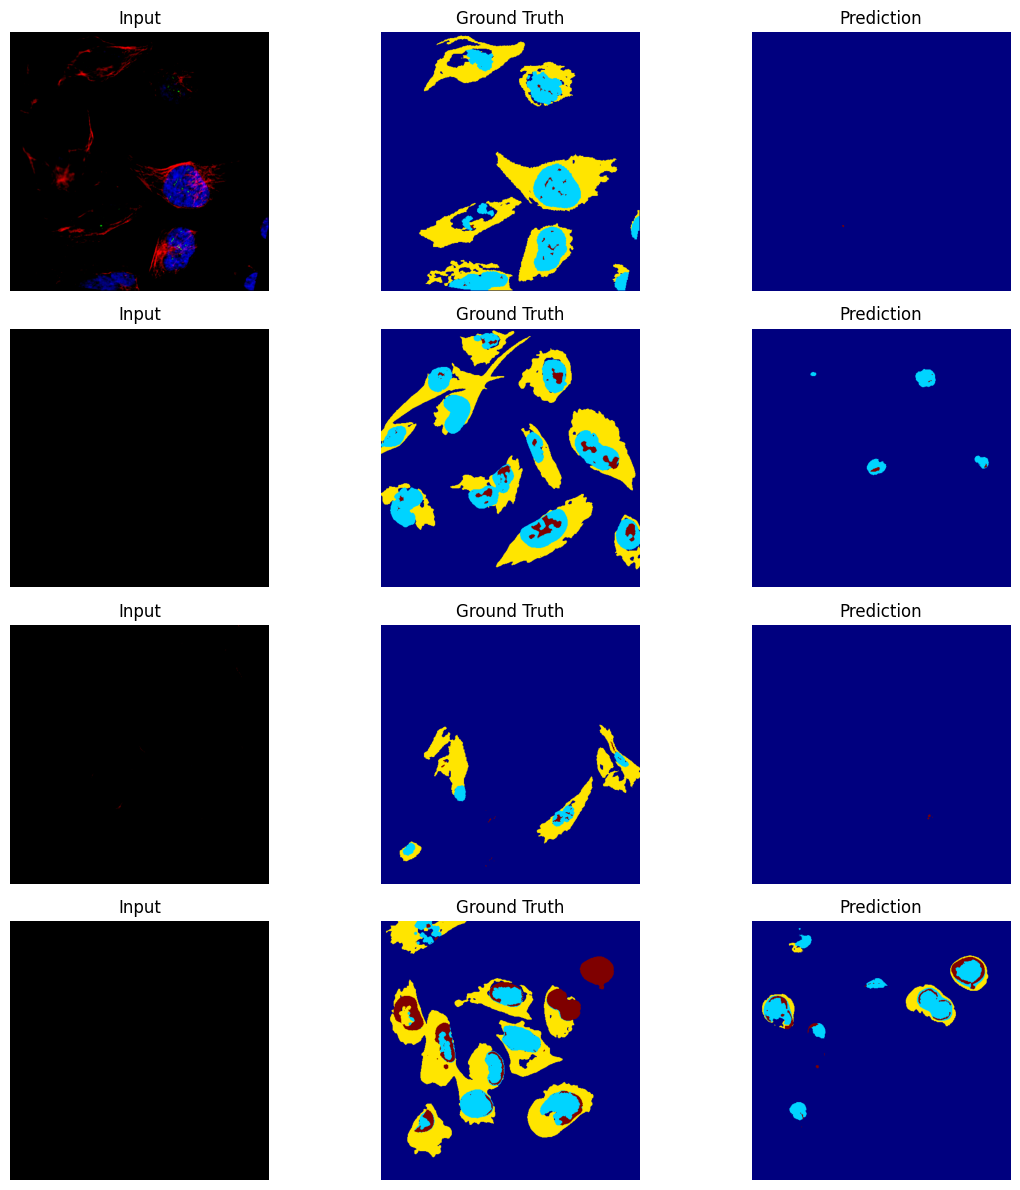

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"


evaluate_model(protein_model, test_loader, device=device, num_samples=4)


In [ ]:
from google.colab import files
files.download("best_unet.pth")


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AttentionUNet(in_channels=3, num_classes=4).to(device)
model.load_state_dict(torch.load("/content/protein_model_.pth", map_location=device))
model.eval()


AttentionUNet(
  (down1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Dropout(p=0.1, inplace=False)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding

In [ ]:
img = cv2.imread("/content/674_C10_1_green.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_resized = cv2.resize(img, (512, 512))

# Normalize same as training
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_norm = (img_resized / 255.0 - mean) / std

img_tensor = torch.tensor(img_norm).permute(2, 0, 1).unsqueeze(0).float().to(device)


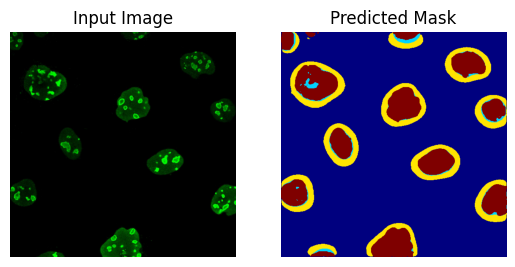

In [ ]:
with torch.no_grad():
    pred = model(img_tensor)
    pred_mask = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()

plt.subplot(1, 2, 1)
plt.imshow(img_resized)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="jet")
plt.title("Predicted Mask")
plt.axis("off")
plt.show()